In [ ]:
#########################
#IMPORT REQUIRED PACKAGES
#########################

import numpy as np
import pandas as pd
import math
def truncate(number, digits) -> float:
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper
from scipy.stats import linregress
from lmfit import Minimizer, Parameters, report_fit
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerBase
import os
from openpyxl import load_workbook
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
class MarkerHandler(HandlerBase):
    def create_artists(self, legend, tup,xdescent, ydescent,
                        width, height, fontsize,trans):
        return [plt.Line2D([width/2], [height/2.],ls="",
                       marker=tup[1],color=tup[0], transform=trans)]
    

#######################################################
#IMPORT PROCESSED EXCEL FILES CONTAINING TITRATION DATA
#######################################################

#FIRST TITRATION (TA TITRATION)
df_TA = pd.read_excel("/Users/dankerr/Desktop/DESKTOP/POSTGRAD/MASTER SEAWATER ANALYSIS/CARBON/Alkalinity Titration/BACK TITRATION/SODIUM ACETATE/PROCESSED_NACO3COO/01.09.21.50UM.001_PROCESSED.xlsx")
#RETURN SAMPLE TO ORIGINAL pH USING NaOH TITRATION
df_NaOH = pd.read_excel("/Users/dankerr/Desktop/DESKTOP/POSTGRAD/MASTER SEAWATER ANALYSIS/CARBON/Alkalinity Titration/BACK TITRATION/SODIUM ACETATE/PROCESSED_NACO3COO/01.09.21.50UM.001.NAOH_PROCESSED.xlsx")
#SECOND TITRATION (BACK TITRATION)
df_BT = pd.read_excel("/Users/dankerr/Desktop/DESKTOP/POSTGRAD/MASTER SEAWATER ANALYSIS/CARBON/Alkalinity Titration/BACK TITRATION/SODIUM ACETATE/PROCESSED_NACO3COO/01.09.21.50UM.001.BT_PROCESSED.xlsx")

In [3]:
    
####################################################################
##DEFINE FUNCTION TO SAVE PROCESSED TA DATA TO TA MASTER SPREADSHEET
####################################################################


def append_df_to_excel(filename, df, sheet_name='Sheet1', startrow=None,
                       truncate_sheet=False, 
                       **to_excel_kwargs):
    """
    Append a DataFrame [df] to existing Excel file [filename]
    into [sheet_name] Sheet.
    If [filename] doesn't exist, then this function will create it.

    @param filename: File path or existing ExcelWriter
                     (Example: '/path/to/file.xlsx')
    @param df: DataFrame to save to workbook
    @param sheet_name: Name of sheet which will contain DataFrame.
                       (default: 'Sheet1')
    @param startrow: upper left cell row to dump data frame.
                     Per default (startrow=None) calculate the last row
                     in the existing DF and write to the next row...
    @param truncate_sheet: truncate (remove and recreate) [sheet_name]
                           before writing DataFrame to Excel file
    @param to_excel_kwargs: arguments which will be passed to `DataFrame.to_excel()`
                            [can be a dictionary]
    @return: None

    Usage examples:

    >>> append_df_to_excel('d:/temp/test.xlsx', df)

    >>> append_df_to_excel('d:/temp/test.xlsx', df, header=None, index=False)

    >>> append_df_to_excel('d:/temp/test.xlsx', df, sheet_name='Sheet2',
                           index=False)

    >>> append_df_to_excel('d:/temp/test.xlsx', df, sheet_name='Sheet2', 
                           index=False, startrow=25)

    (c) [MaxU](https://stackoverflow.com/users/5741205/maxu?tab=profile)
    """
    # Excel file doesn't exist - saving and exiting
    if not os.path.isfile(filename):
        df.to_excel(
            filename,
            sheet_name=sheet_name, 
            startrow=startrow if startrow is not None else 0, 
            **to_excel_kwargs)
        return
    
    # ignore [engine] parameter if it was passed
    if 'engine' in to_excel_kwargs:
        to_excel_kwargs.pop('engine')

    writer = pd.ExcelWriter(filename, engine='openpyxl', mode='a')

    # try to open an existing workbook
    writer.book = load_workbook(filename)
    
    # get the last row in the existing Excel sheet
    # if it was not specified explicitly
    if startrow is None and sheet_name in writer.book.sheetnames:
        startrow = writer.book[sheet_name].max_row

    # truncate sheet
    if truncate_sheet and sheet_name in writer.book.sheetnames:
        # index of [sheet_name] sheet
        idx = writer.book.sheetnames.index(sheet_name)
        # remove [sheet_name]
        writer.book.remove(writer.book.worksheets[idx])
        # create an empty sheet [sheet_name] using old index
        writer.book.create_sheet(sheet_name, idx)
    
    # copy existing sheets
    writer.sheets = {ws.title:ws for ws in writer.book.worksheets}

    if startrow is None:
        startrow = 0

    # write out the new sheet
    df.to_excel(writer, sheet_name, startrow=startrow, **to_excel_kwargs)

    # save the workbook
    writer.save()
    



##############################################################################################################################
##############################################################################################################################
################################## FIRST TITRATION (TA TITRATION) ############################################################
##############################################################################################################################
##############################################################################################################################


##################
#ACID TITRANT INFO
##################
C = 0.10060392 # Estimate of OVERALL HCl titrant concentration (mol.kg-1) from CRM_182_0392 
Cl_HCl = 0.10060392 #ionic strength of acid, 0.1M HCl made up in DI therefore [Cl-] = 0.1 M

#######################################################
#CONSTANTS CALCULATED BASED ON SALINITY AND TEMPERATURE 
#######################################################
R = 8.314472 # Universal gas constant
F = 96485.3399 # Faraday constant

################################
#EXTRACT DATA FROM TA EXCEL FILE
################################
V0 = df_TA.iloc[0]['g_0']-df_TA.iloc[0]['g_1'] # Sample mass (g)
S_TA = df_TA.iloc[0]['SALINITY']  # Sample Salinity 
sample_id_TA = df_TA.iloc[0]['SAMPLE']  # Sample ID
data_start_TA = int(df_TA.iloc[0]['data_start']-1) #row which titration starts, eg after initial acid addition and degassing
initial_EV_TA = df_TA.iloc[9]['102 Voltage (V)'] #EV of sample before any acid addition, at index = 10



#######################################################################################################################
#strip data from df such that index = 1 aligns with start of titration eg after initial acid addition and degassing
#######################################################################################################################
df_TA['E(V)'] = df_TA.drop(df_TA.index[0:data_start_TA],axis=0)['102 Voltage (V)']
df_TA['E(V)'] = df_TA['E(V)'].shift(-(data_start_TA))
df_TA['Sample_T'] = df_TA.drop(df_TA.index[0:data_start_TA],axis=0)['SAMPLE Temperature (°C)']
df_TA['Sample_T'] = df_TA['Sample_T'].shift(-(data_start_TA))
df_TA['Acid_T'] = df_TA.drop(df_TA.index[0:data_start_TA],axis=0)['ACID Temperature (°C)']
df_TA['Acid_T'] = df_TA['Acid_T'].shift(-(data_start_TA))
stripped_df_TA = df_TA[['E(V)', 'Sample_T', 'Acid_T', "mL"]].copy() #copy above variables to new "stripped_df"
stripped_df_TA = stripped_df_TA.dropna() #remove NaN values from stripped_df
df_TA = stripped_df_TA #for congruency with existing code, redefine stripped_df as df
 

#####################################
#SAMPLE TEMPERATURE AND NERNST FACTOR
#####################################
T_TA = df_TA["T"] = (df_TA["Sample_T"]+273.15)  # CREATE COLUMN SAMPLE TEMPERATURE (KELVIN) AT EACH TITRATION POINT
df_TA["K"] = (R*T_TA)/F # Nernst factor 
initial_K_TA = df_TA.iloc[9]['K'] # Initial Nernst factor, used to calculate initial pH


###################################################
#ACID DENSITY, CONVERSION FROM VOLUME TO MASS UNITS
###################################################
df_TA["rho"] = (df_TA["Acid_T"]*-0.0008958+1.02119193) #  CREATE COLUMN OF DENSITY (g.cm-3) OF ACID AT EACH TITRATION POINT
initial_mL_acid = df_TA.iloc[0]["mL"] #define value for initial volume acid added (mL)
intial_g_acid = initial_mL_acid*df_TA.iloc[0]["rho"]#convert inital volume of acid added to mass value (g)
df_TA['delta_mL'] = df_TA['mL'].diff() #calculate the incremental values of volume of acid added
df_TA['delta_g'] = df_TA['delta_mL']*df_TA["rho"] #convert the incremental values of volume of acid added to mass values
df_TA = df_TA.fillna(0) #initial value of df['delta_g'] will be NA by default, replace with 0
df_TA['m'] = intial_g_acid+np.cumsum(df_TA['delta_g'])#caculate cumulative total of mass of acid added, (intial mass of acid added + incremment mass 1,  intial mass of acid added + incremment mass 1 + incremment mass 2 ...)

############################
#IONIC STRENGTH AND SALINITY 
############################
ImO_TA = (19.924*S_TA/(1000-1.005*S_TA)) # ionic strength from Dickson 2007
df_TA['ImO'] = (ImO_TA*V0+df_TA.m*(Cl_HCl))/(V0+df_TA.m) # ionic strength adjusted for addition of acid
df_TA["S"] = (1000*df_TA.ImO)/(19.924+1.005*df_TA.ImO) # salinity adjusted for addition of acid


############################################################
#EQUILIBRIUM CONSTANTS, BISULFATE ION AND HYDROGEN FLUORIDE  
############################################################
df_TA['K_S'] = np.exp(-4276.1/T_TA + 141.328 - 23.093*np.log(T_TA)+(-13856/T_TA + 324.57- 47.986*np.log(T_TA))*(ImO_TA**(1/2)) +(35474/T_TA  - 771.54 +114.723*np.log(T_TA))*ImO_TA - (2698/T_TA)*(ImO_TA)**(3/2)+(1776/T_TA)*(ImO_TA)**(2) +np.log(1-0.001005*S_TA)) # pKa Bisulfate ion [HSO4-] K_S from Dickson1990
df_TA['K_F'] = np.exp(874/T_TA - 9.68 + 0.111*S_TA**0.5)  # pKa Hydrogen Fluoride ion [HF] K_F  from Perex & Fraga 1987

#####################################
#TOTAL SULPHATE AND HYDROGEN FLUORIDE 
#####################################
df_TA['S_T'] =  (0.14/96.062)*(df_TA.S/1.80655)# Total Sulphate concentration S_T from Morris & Riley 1966
df_TA['F_T'] = (0.000067/18.998)*(df_TA.S/1.80655) # Total Hydrogen Fluoride concentration F_T from Riley 1996
df_TA["Z"] = (1+df_TA.S_T/df_TA.K_S) #from dickson 2007 Z = (1+S_T/K_S) 

################################################################
#GRAN FUNCTION, IDENTIFY TA INITIAL ESTIMATE AND E0, INITIAL GRAN [H'] AND GRAN pH
################################################################
df_TA["F1"] = ((V0+df_TA["m"])*np.exp((df_TA["E(V)"]/(df_TA.K)))) #Calculate Gran Function F1 at each titration point
df_TA = df_TA[df_TA["F1"].between(10000, 1000000)] #drop all gran funciton values less than 10000 as these are TYPICALLY non linear with respect to m
slope, intercept, r_value, p_value, std_err =linregress(df_TA["m"], df_TA["F1"])#CALL SLOPE AND INTERCEPT OF Gran function F1
equivalence_point_TA = -intercept/slope #Calculate equivalnce point estimate (g) from Gran function F1
TA_est_TA = (equivalence_point_TA*C)/V0#Estimate TA using equivalnce point estimate

df_TA["E0_est"] = (df_TA["E(V)"]-(df_TA["K"])*np.log((-V0*TA_est_TA + df_TA["m"]*C)/(V0 + df_TA["m"]))) #CALCULATE EO ESTIMATE FOR EACH TITRATION POINT
E0_init_est_TA = df_TA["E0_est"].mean()#AVERAGE ALL EO VALUES TO OBTAIN AN INITIAL ESTIMATE OF EO
df_TA["H"] = (np.exp((df_TA["E(V)"]-E0_init_est_TA)/(df_TA["K"]))) #USING EO INITIAL ESTIMATE CALCULATE [H'] FOR EACH TITRATION POINT
df_TA["GRAN_pH"] = -(np.log10(np.exp((df_TA["E(V)"]-E0_init_est_TA)/df_TA["K"])))#CALCULATE GRAN pH


##########################################
#TA EQUATION TO DEFINE VECTOR OF RESIDUALS
##########################################
f = 1 #define f and provide inital estimate
df_TA["residuals"] = TA_est_TA  + ((V0+df_TA.m)/V0)*((f*df_TA.H)/df_TA.Z) -(df_TA.m/V0)*C # DEFINE RESIDUALS
SSR = (np.sum((TA_est_TA + ((V0+df_TA.m)/V0)*((f*df_TA.H)/df_TA.Z) -(df_TA.m/V0)*C )**2))*10**12 # DEFINE SSR EQUATION


#################################################
#NON LINEAR LEAST SQUARES CURVE FITTING PROCEDURE
#################################################

new_df_TA = df_TA[df_TA["GRAN_pH"].between(3, 3.5)]#SELECT ONLY TITRATION POINTS WHICH pH ARE BETWEEN 3.0 - 3.5 
data_points_TA = len(new_df_TA.index) #CALCULATE NUMBER OF DATA POINTS IN 3-3.5 pH RANGE

# DEFINE FUNCTION WHICH RETURNS VALUE(S) TO BE MINIMISED, IN THIS CASE SSR 
x_TA = new_df_TA.H
data_TA = new_df_TA.m

def fcn2min(params, x_TA, data_TA):
    f_NLSF_TA = params['f_NLSF_TA']
    TA_est_NLSF_TA = params['TA_est_NLSF_TA']
    model = ((np.sum((TA_est_NLSF_TA + 
                      ((V0+new_df_TA.m)/V0)*
                      ((f_NLSF_TA*new_df_TA.H)/new_df_TA.Z) -
                      (new_df_TA.m/V0)*C)**2))*10**12)
    
    return model - data_TA

# create a set of Parameters
params = Parameters()
params.add('f_NLSF_TA',   value= 1)
params.add('TA_est_NLSF_TA', value= TA_est_TA)
# do fit, here with leastsq model
minner = Minimizer(fcn2min, params, fcn_args=(x_TA, data_TA))
kws  = {'options': {'maxiter':10}}
result = minner.minimize()
# calculate final result
final = data_TA + result.residual


#################################
#EXTRACT AND PROCESS TA NLSF RESULTS
#################################
TA_processed_TA = result.params.get('TA_est_NLSF_TA').value #EXTRACT INTIAL TA VALUE M/KG-1
TA_final_TA = TA_processed_TA*10**6 #COVERT INTIAL TA VALUE TO µmol/KG-1
f_TA = result.params.get('f_NLSF_TA').value #EXTRACT NLSF F VALUE
E0_processed_TA = E0_init_est_TA + df_TA["K"]*np.log(f) #CALCULATE E0 FROM NLSF F VALUE
E0_final_TA = E0_processed_TA.mean() #FINAL ESTIMATE OF E0
new_df_TA["pH"] = -np.log10(np.exp((df_TA["E(V)"]-E0_final_TA)/df_TA["K"])) #CALCULATE pH AT EACH TITRATION POINT FROM E0 FINAL ESTIMATE
initial_pH_TA = -np.log10(np.exp((initial_EV_TA-E0_final_TA)/initial_K_TA)) #CALCULATE INTIAL pH FROM E0 FINAL ESTIMATE







##############################################################################################################################
##############################################################################################################################
################################## NAOH TITRATION ############################################################################
##############################################################################################################################
##############################################################################################################################

##################
#BASE TITRANT INFO
##################
C_NaOH = 0.082744091 # ± 0.000226775 determimed from acidic gran function of standardisation of NaOH using crm standardised HCl
I_NaOH = 0.082744091 #ionic strength of NaOH 

################################
#EXTRACT DATA FROM TA EXCEL FILE
################################
df_NaOH["T"] = (df_NaOH["SAMPLE Temperature (°C)"]+273.15) #create colume for sample temperature (KELVIN) at each titration point
df_NaOH["NaOH_T"] = df_NaOH["NaOH Temperature (°C)"] #create colume for temperature (Degrees Celsius) of NaOH upon addition to cell 

###################################################
#BASE DENSITY, CONVERSION FROM VOLUME TO MASS UNITS
###################################################
df_NaOH["rho"] = (df_NaOH["NaOH_T"]*-0.014702658+1.27068345) # Density of NaOH titrant g.cm-3 
initial_mL_base = 0 #define value for initial volume base added (mL)
intial_g_base = initial_mL_base*df_NaOH.iloc[0]["rho"]#convert inital volume of base added to mass value (g)
df_NaOH['delta_mL'] = df_NaOH['mL'].diff() #calculate the incremental values of volume of base added
df_NaOH['delta_g'] = df_NaOH['delta_mL']*df_NaOH["rho"] #convert the incremental values of volume of base added to mass values
#df_NaOH = df_NaOH.fillna(0) #initial value of df['delta_g'] will be NA by default, replace with 0
df_NaOH['delta_g'] = df_NaOH['delta_g'].fillna(0)
df_NaOH['m'] = intial_g_base+np.cumsum(df_NaOH['delta_g'])#caculate cumulative total of mass of base added, (intial mass of acid added + incremment mass 1,  intial mass of acid added + incremment mass 1 + incremment mass 2 ...)

############################
#IONIC STRENGTH AND SALINITY 
############################
Va = df_TA['m'][df_TA.index[-1]] #DEFINE TOTAL MASS OF ACID ADDED DURING FIRST (TA) TITRATION
Vb = df_NaOH['m'][df_NaOH.index[-1]] #DEFINE TOTAL MASS OF BASE ADDED DURING NAOH TITRATION

S_NaOH_initial = df_TA['S'][df_TA.index[-1]] #INITIAL SALINITY VALUE FOR NAOH TITRATION DEFINED AS LAST salinty value of FIRST titration (TA TITRATION), which factors in slight dilution due to addition of acid
ImO_NaOH_initial = (19.924*S_NaOH_initial/(1000-1.005*S_NaOH_initial)) #calculate INTIAL ImO from this S value
df_NaOH['ImO_NaOH'] = (ImO_NaOH_initial*(V0+Va)+(df_NaOH['m']*I_NaOH))/(V0 + Va + df_NaOH['m']) # FINAL IMO VALUE AT END OF NAOH TITRATION
df_NaOH['S'] = (1000*df_NaOH['ImO_NaOH'])/(19.924+1.005*df_NaOH['ImO_NaOH']) # FINAL SALINITY VALUE AT END OF NAOH TITRATION
S_NaOH_final = df_NaOH['S'][df_NaOH.index[-1]]


###############################
#CALCULATE pH, [H+], [OH-], H0
###############################
df_NaOH["K"] = (R*df_NaOH["T"])/F #Get K value at eachpoint during NaOH titration
df_NaOH["pH"] = -np.log10(np.exp((df_NaOH["102 Voltage (V)"]-E0_final_TA)/df_NaOH["K"]))#Using EO estimated from TA NLSF procedure calculate pH at each point during NaOH titration
df_NaOH["H"] = 10**-(df_NaOH["pH"]) #Using pH calculate [H+] at each titration point
df_NaOH['pKw'] = (-np.log10(np.exp(148.9652-13847.26/df_NaOH["T"]-23.6521*np.log(df_NaOH["T"])+(-5.977+118.67/df_NaOH["T"]+1.0495*np.log(df_NaOH["T"]))*df_NaOH["S"]**0.5-0.01615*df_NaOH["S"]))) #Acid dissociation constant of Water
df_NaOH['OH'] = (10**-df_NaOH["pKw"])/df_NaOH["H"] #using Acid dissociation constant of Water and [H+] calculate [OH-]
initial_EV_NaOH = df_NaOH.iloc[0]['102 Voltage (V)'] #Proton concentration prior to NaOH addition, H0, defined as [H+] at end of first (TA) titration (start of NaOH titration)
initial_K_NaOH = df_NaOH.iloc[0]['K']
H0 = (np.exp((initial_EV_NaOH-E0_final_TA)/(initial_K_NaOH)))






##############################################################################################################################
##############################################################################################################################
################################## SECOND TITRATION (BT TITRATION) ###########################################################
##############################################################################################################################
##############################################################################################################################


################################
#EXTRACT DATA FROM TA EXCEL FILE
################################
V0_BT = (V0+Va+Vb) # Sample mass accounting for additions of acid and base (g) 
sample_id_BT = df_BT.iloc[0]['SAMPLE']  # Sample ID
data_start_BT = int(df_BT.iloc[0]['data_start']-1) #row which titration starts, eg after initial acid addition and degassing


#######################################################################################################################
#strip data from df such that index = 1 aligns with start of titration eg after initial acid addition and degassing
#######################################################################################################################
df_BT['E(V)'] = df_BT.drop(df_BT.index[0:data_start_BT],axis=0)['102 Voltage (V)']
df_BT['E(V)'] = df_BT['E(V)'].shift(-(data_start_BT))
df_BT['Sample_T'] = df_BT.drop(df_BT.index[0:data_start_BT],axis=0)['SAMPLE Temperature (°C)']
df_BT['Sample_T'] = df_BT['Sample_T'].shift(-(data_start_BT))
df_BT['Acid_T'] = df_BT.drop(df_BT.index[0:data_start_BT],axis=0)['ACID Temperature (°C)']
df_BT['Acid_T'] = df_BT['Acid_T'].shift(-(data_start_BT))
#copy above variables to new "stripped_df_BT"
stripped_df_BT = df_BT[['E(V)', 'Sample_T', 'Acid_T', "mL"]].copy()
#remove NaN values from stripped_df_BT
stripped_df_BT = stripped_df_BT.dropna()
#for congruency with existing code, redefine stripped_df_BT as df_BT
df_BT = stripped_df_BT

###################################################
#ACID DENSITY, CONVERSION FROM VOLUME TO MASS UNITS
###################################################
df_BT["rho"] = (df_BT["Acid_T"]*-0.0008958+1.02119193) #  CREATE COLUMN OF DENSITY (g.cm-3) OF ACID AT EACH TITRATION POINT
initial_mL_acid = df_BT.iloc[0]["mL"] #define value for initial volume acid added (mL)
intial_g_acid = initial_mL_acid*df_BT.iloc[0]["rho"]#convert inital volume of acid added to mass value (g)
df_BT['delta_mL'] = df_BT['mL'].diff() #calculate the incremental values of volume of acid added
df_BT['delta_g'] = df_BT['delta_mL']*df_BT["rho"] #convert the incremental values of volume of acid added to mass values
df_BT = df_BT.fillna(0) #initial value of df['delta_g'] will be NA by default, replace with 0
df_BT['m'] = intial_g_acid+np.cumsum(df_BT['delta_g'])#caculate cumulative total of mass of acid added, (intial mass of acid added + incremment mass 1,  intial mass of acid added + incremment mass 1 + incremment mass 2 ...)

#####################################
#SAMPLE TEMPERATURE AND NERNST FACTOR
#####################################
T_BT = df_BT["T"] = (df_BT["Sample_T"]+273.15)  # CREATE COLUMN SAMPLE TEMPERATURE (KELVIN) AT EACH TITRATION POINT
df_BT["K"] = (R*T_BT)/F # Nernst factor 
initial_K_BT = df_BT.iloc[0]['K'] # Initial Nernst factor, used to calculate initial pH
initial_EV_BT = df_BT.iloc[0]['E(V)'] #EV of sample before any acid addition

############################
#IONIC STRENGTH AND SALINITY 
############################
S_BT = S_NaOH_final #intial Salinity value of second (BT) titration is defined as last Salinity value of NaOH titration
ImO_BT = (19.924*S_BT/(1000-1.005*S_BT)) # ionic strength from Dickson 2007
df_BT['ImO'] = (ImO_BT*V0_BT+df_BT.m*(Cl_HCl))/(V0_BT+df_BT.m) # ionic strength adjusted for addition of acid
df_BT["S"] = (1000*df_BT.ImO)/(19.924+1.005*df_BT.ImO) # salinity adjusted for addition of acid


############################################################
#EQUILIBRIUM CONSTANTS, BISULFATE ION AND HYDROGEN FLUORIDE  
############################################################
df_BT['K_S'] = np.exp(-4276.1/T_BT + 141.328 - 23.093*np.log(T_BT)+(-13856/T_BT + 324.57- 47.986*np.log(T_BT))*(ImO_BT**(1/2)) +(35474/T_BT  - 771.54 +114.723*np.log(T_BT))*ImO_BT - (2698/T_BT)*(ImO_BT)**(3/2)+(1776/T_BT)*(ImO_BT)**(2) +np.log(1-0.001005*S_BT)) # pKa Bisulfate ion [HSO4-] K_S from Dickson1990
df_BT['K_F'] = np.exp(874/T_BT - 9.68 + 0.111*S_BT**0.5)  # pKa Hydrogen Fluoride ion [HF] K_F  from Perex & Fraga 1987

#####################################
#TOTAL SULPHATE AND HYDROGEN FLUORIDE 
#####################################
df_BT['S_T'] =  (0.14/96.062)*(df_BT.S/1.80655)# Total Sulphate concentration S_T from Morris & Riley 1966
df_BT['F_T'] = (0.000067/18.998)*(df_BT.S/1.80655) # Total Hydrogen Fluoride concentration F_T from Riley 1996
df_BT["Z"] = (1+df_BT.S_T/df_BT.K_S) #from dickson 2007 Z = (1+S_T/K_S) 

################################################################
#GRAN FUNCTION, IDENTIFY TA INITIAL ESTIMATE AND E0, INITIAL GRAN [H'] AND GRAN pH
################################################################
df_BT["F1"] = ((V0_BT+df_BT["m"])*np.exp((df_BT["E(V)"]/(df_BT.K)))) #Calculate Gran Function F1 at each titration point
df_BT = df_BT[df_BT["F1"].between(10000, 1000000)] #drop all gran funciton values less than 10000 as these are TYPICALLY non linear with respect to m
slope, intercept, r_value, p_value, std_err =linregress(df_BT["m"], df_BT["F1"])#CALL SLOPE AND INTERCEPT OF Gran function F1
equivalence_point_BT = -intercept/slope #Calculate equivalnce point estimate (g) from Gran function F1
TA_est_BT = (equivalence_point_BT*C)/V0_BT#Estimate TA using equivalnce point estimate

df_BT["E0_est"] = (df_BT["E(V)"]-(df_BT["K"])*np.log((-V0_BT*TA_est_BT + df_BT["m"]*C)/(V0_BT + df_BT["m"]))) #CALCULATE EO ESTIMATE FOR EACH TITRATION POINT
E0_init_est_BT = df_BT["E0_est"].mean()#AVERAGE ALL EO VALUES TO OBTAIN AN INITIAL ESTIMATE OF EO
df_BT["H"] = (np.exp((df_BT["E(V)"]-E0_init_est_BT)/(df_BT["K"]))) #USING EO INITIAL ESTIMATE CALCULATE [H'] FOR EACH TITRATION POINT
df_BT["GRAN_pH"] = -(np.log10(np.exp((df_BT["E(V)"]-E0_init_est_BT)/df_BT["K"])))#CALCULATE GRAN pH


##########################################
#TA EQUATION TO DEFINE VECTOR OF RESIDUALS
##########################################
f = 1 #define f and provide inital estimate
df_BT["residuals"] = TA_est_BT  + ((V0_BT+df_BT.m)/V0_BT)*((f*df_BT.H)/df_BT.Z) -(df_BT.m/V0_BT)*C # DEFINE RESIDUALS
SSR = (np.sum((TA_est_BT + ((V0_BT+df_BT.m)/V0_BT)*((f*df_BT.H)/df_BT.Z) -(df_BT.m/V0_BT)*C )**2))*10**12 # DEFINE SSR EQUATION


#################################################
#NON LINEAR LEAST SQUARES CURVE FITTING PROCEDURE
#################################################

new_df_BT = df_BT[df_BT["GRAN_pH"].between(3, 3.5)]#SELECT ONLY TITRATION POINTS WHICH pH ARE BETWEEN 3.0 - 3.5 
data_points_BT = len(new_df_BT.index) #CALCULATE NUMBER OF DATA POINTS IN 3-3.5 pH RANGE

# DEFINE FUNCTION WHICH RETURNS VALUE(S) TO BE MINIMISED, IN THIS CASE SSR 
x_BT = new_df_BT.H
data_BT = new_df_BT.m

def fcn2min(params, x_BT, data_BT):
    f_NLSF_BT = params['f_NLSF_BT']
    TA_est_NLSF_BT = params['TA_est_NLSF_BT']
    model = ((np.sum((TA_est_NLSF_BT + 
                      ((V0_BT+new_df_BT.m)/V0_BT)*
                      ((f_NLSF_BT*new_df_BT.H)/new_df_BT.Z) -
                      (new_df_BT.m/V0_BT)*C)**2))*10**12)
    
    return model - data_BT

# create a set of Parameters
params = Parameters()
params.add('f_NLSF_BT',   value= 1)
params.add('TA_est_NLSF_BT', value= TA_est_BT)
# do fit, here with leastsq model
minner = Minimizer(fcn2min, params, fcn_args=(x_BT, data_BT))
kws  = {'options': {'maxiter':10}}
result = minner.minimize()
# calculate final result
final = data_BT + result.residual


#################################
#EXTRACT AND PROCESS TA NLSF RESULTS
#################################
TA_processed_BT = result.params.get('TA_est_NLSF_BT').value #EXTRACT INTIAL TA VALUE M/KG-1
TA_final_BT = TA_processed_BT*10**6 #COVERT INTIAL TA VALUE TO µmol/KG-1
f_BT = result.params.get('f_NLSF_BT').value #EXTRACT NLSF F VALUE
E0_processed_BT = E0_init_est_BT + df_BT["K"]*np.log(f_BT) #CALCULATE E0 FROM NLSF F VALUE
E0_final_BT = E0_processed_BT.mean() #FINAL ESTIMATE OF E0
new_df_BT["pH"] = -np.log10(np.exp((df_BT["E(V)"]-E0_final_BT)/df_BT["K"])) #CALCULATE pH AT EACH TITRATION POINT FROM E0 FINAL ESTIMATE
initial_pH_BT = -np.log10(np.exp((initial_EV_BT-E0_final_BT)/initial_K_BT)) #CALCULATE INTIAL pH FROM E0 FINAL ESTIMATE

print('TA: ', TA_final_TA, 'µmol.kg-1')
print('OrgAlk: ', TA_final_BT, 'µmol.kg-1')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/dankerr/Desktop/DESKTOP/POSTGRAD/MASTER SEAWATER ANALYSIS/CARBON/Alkalinity Titration/BACK TITRATION/SODIUM ACETATE/PROCESSED_NACO3COO/01.09.21.50UM.001_PROCESSED.xlsx'

In [14]:
##############################################################################################################################
##############################################################################################################################
################################## OrgAlk Characterisation ###################################################################
##############################################################################################################################
##############################################################################################################################

###############################################################
#EQUILIBRIUM CONSTANTS, CO2 system, Boric Acid, Phosphoric Acid
###############################################################
#K1 and K2 from Lueker et al., 2000
df_NaOH["pK1_LK"] = 3633.86/df_NaOH["T"] - 61.2172 +9.67770*np.log(df_NaOH["T"]) - 0.011555*df_NaOH["S"] + 0.0001152*df_NaOH["S"]**2 
df_NaOH["pK2_LK"] = 471.78/df_NaOH["T"] + 25.9290 - 3.16967*np.log(df_NaOH["T"]) - 0.01781*df_NaOH["S"] + 0.0001122*df_NaOH["S"]**2 
df_NaOH["K1_LK"] = 10**-df_NaOH["pK1_LK"] 
df_NaOH["K2_LK"] = 10**-df_NaOH["pK2_LK"]
#K1 and K2 from Mehrbach et al. (1973)
df_NaOH["pK1_MB"] = -13.7201+0.031334*df_NaOH["T"] + 3235.76/df_NaOH["T"] + (1.300*10**-5)*df_NaOH["S"]*df_NaOH["T"] - 0.1032*df_NaOH["S"]**0.5
df_NaOH["pK2_MB"] = 5371.9645+1.671221*df_NaOH["T"]+0.22913*df_NaOH["S"]+18.3802*np.log10(df_NaOH["S"])-128375.28/df_NaOH["T"]-2194.3055*np.log10(df_NaOH["T"])-(8.0944*10**-4)*df_NaOH["S"]*df_NaOH["T"]-5617.11*np.log10(df_NaOH["S"])/df_NaOH["T"] + 2.136*df_NaOH["S"]/df_NaOH["T"]
df_NaOH["K1_MB"] = 10**-df_NaOH["pK1_MB"] 
df_NaOH["K2_MB"] = 10**-df_NaOH["pK2_MB"]
#EQUILIBRIUM CONSTANT FOR THE DISSOCIATION OF BORIC ACID, KB (DICKSON1990B)
df_NaOH['KB'] = (-8966.90 - 2890.53*df_NaOH["S"]**0.5 - 77.942*df_NaOH["S"] + 1.728*df_NaOH["S"]**1.5 - 0.0996*df_NaOH["S"]**2)/df_NaOH["T"] +(148.0248 + 137.1942*df_NaOH["S"]**0.5 + 1.62142*df_NaOH["S"])+(-24.4344-25.085*df_NaOH["S"]**0.5 - 0.2474*df_NaOH["S"])*np.log(df_NaOH["T"])+ (0.053105*df_NaOH["S"]**0.5)*df_NaOH["T"]
#pK1, pK2, pK3 for phosphoric acid from Millero1995
#df_NaOH['KP1'] = -4576.752/df_NaOH["T"] + 115.525 - 18.453*np.log(df_NaOH["T"]) + (-106.736/df_NaOH["T"] + 0.69171)*df_NaOH["S"]**0.5 + (-0.65643/df_NaOH["T"] - 0.01844)*df_NaOH["S"] 
#df_NaOH['KP2'] = -8814.715/df_NaOH["T"] + 172.0883 - 27.927*np.log(df_NaOH["T"]) + (-160.34/df_NaOH["T"] + 1.3566)*df_NaOH["S"]**0.5 + (0.37335/df_NaOH["T"] - 0.05778)*df_NaOH["S"] 
#df_NaOH['KP3'] = -3070.75/df_NaOH["T"] - 18.141 + (17.27039/df_NaOH["T"] + 2.81197)*df_NaOH["S"]**0.5 + (-44.99486/df_NaOH["T"] - 0.09984)*df_NaOH["S"]

######################
#Total Boron, Silicate 
######################
BT = 0.0004157*S_TA/35 #TOTAL BORON [BT], (LEE2010) S VALUE IS ORIGIONAL SAMPLE S


#Ko2016 CO2 term NO B TERM
#Create variable for content of the NaOH titrant µmol.kg-1 
CO2 = 0# 14.9935212785335*(Vb/1000)


Xi = 1*10**-6 #SIMULATED value
Ki = 10**-4.5 #SIMULATED value

df_NaOH['CB_Ko2016'] = (V0*(Xi/(1+df_NaOH["H"]/Ki))
                            #+ V0*(BT/(1+df_NaOH["H"]/df_NaOH["KB"]))
                            + V0*(CO2/(1+(df_NaOH["H"]/(df_NaOH["K1_LK"]))+df_NaOH["K2_LK"]/df_NaOH["H"])) 
                            - (V0 + Va + df_NaOH['m'])*(df_NaOH["H"]-df_NaOH["OH"]) 
                            + (V0 + Va)*H0
                            - df_NaOH['m']*C_NaOH
                           )
#copy above variables to new "stripped_df"
new_df_NaOH = df_NaOH[['H', 'OH', 'm', "K1_LK", "K2_LK","pK1_LK", "pK2_LK", "pH", "K1_MB", "K2_MB","pK1_MB", "pK2_MB", "KB",  'CB_Ko2016']].copy()
#remove NaN values from stripped_df
new_df_NaOH.dropna(inplace= True)
new_df_NaOH.reset_index(inplace=True)


X1_initial = TA_processed_BT #inital Xi = OrgAlk µmol.kg
X2_initial = TA_processed_BT #inital Xi = OrgAlk µmol.kg
X3_initial = TA_processed_BT #inital Xi = OrgAlk µmol.kg

K_X1_initial = 10**-4.5 #midpoint pH 3 - 7
K_X2_initial = 10**-5.25 #midpoint pH 3 - 7.5
K_X3_initial = 10**-5.5 #midpoint pH 3 - 8 (pH 8 approximate max pH)



#SELECT ONLY TITRATION POINTS WHICH pH ARE BETWEEN 0 - 5 
df_constrain_001 = new_df_NaOH[new_df_NaOH["pH"].between(0, 5)]
data_points_001 = len(df_constrain_001)

#SELECT ONLY TITRATION POINTS WHICH pH ARE BETWEEN 5 - 6.5 
df_constrain_002 = new_df_NaOH[new_df_NaOH["pH"].between(0, 6.5)]
data_points_002 = len(df_constrain_002)
#C_NaOH = 0.082744091
#0.08331106906132031 NLSF GENERATED VALUE  
#0.082744091 ACTUAL GRAN TITRATION STANDARDISATION OF NAOH USING CRM STANDARDISED HCL




In [15]:
##################################################################
############################## 001 ###############################
##################################################################
# Data in pH range 0-5 used to constrain H0, X1, K_X1
##################################################################

def minner_001():
    global H0, X1, K_X1

    x_NaOH = df_constrain_001.m
    data_NaOH = df_constrain_001.H


    # DEFINE FUNCTION WHICH RETURNS VALUE(S) TO BE MINIMISED, IN THIS CASE SSR 
    def fcn2min(params, x_NaOH, data_NaOH):
        H0 = params['H0']
        C_NaOH = params['C_NaOH']
        X1 = params['X1']
        K_X1 = params['K_X1']

        model = ((V0 + Va+ df_constrain_001["m"])*(df_constrain_001["H"]-df_constrain_001["OH"]) 
                 -((V0+Va)*H0)
                 +(df_constrain_001["m"]*C_NaOH) 
                 #- V0*(BT/(1+df_constrain_001["H"]/df_constrain_001["KB"]))
                 - (V0)*(CO2/(1+(df_constrain_001["H"]/(df_constrain_001["K1_LK"]))+df_constrain_001["K2_LK"]/df_constrain_001["H"]))
                 - (V0)*(X1/(1+df_constrain_001["H"]/K_X1))
                 #- (V0)*(X2/(1+df_constrain_001["H"]/K_X3))
                 #- (V0)*(X2/(1+df_constrain_001["H"]/K_X3))
                )


        return model - data_NaOH

    # create a set of Parameters
    params = Parameters()
    params.add('H0',   value= H0 ) #highest [H+] value used as initial estimate
    params.add('C_NaOH',   value= C_NaOH, vary = False ) 
    params.add('X1',   value= X1_initial, min = 0 )
    params.add('K_X1',   value= K_X1_initial, min = 0  )

    # do fit, here with leastsq model
    minner = Minimizer(fcn2min, params, fcn_args=(x_NaOH, data_NaOH))
    kws  = {'options': {'maxiter':100}}
    result = minner.minimize()

    # calculate final result
    final = data_NaOH + result.residual
    

    H0 = result.params.get('H0').value
    H0_std = result.params.get('H0').stderr

    X1 = result.params.get('X1').value
    X1_std = result.params.get('X1').stderr
    K_X1 = result.params.get('K_X1').value
    K_X1_std = result.params.get('K_X1').stderr



##################################################################
############################## 002 ###############################
##################################################################
# H0 fixed
# Data in pH range 0-7.5 to fix X1, KX1
##################################################################

def minner_002():
    global H0, C_NaOH, X1, K_X1, X2, K_X2

    x_NaOH = df_constrain_002.m
    data_NaOH = df_constrain_002.H
    # DEFINE FUNCTION WHICH RETURNS VALUE(S) TO BE MINIMISED, IN THIS CASE SSR 
    def fcn2min(params, x_NaOH, data_NaOH):
        H0 = params['H0']
        C_NaOH = params['C_NaOH']
        X1 = params['X1']
        K_X1 = params['K_X1']
        X2 = params['X2']
        K_X2 = params['K_X2']

        model = ((V0 + Va+ df_constrain_002["m"])*(df_constrain_002["H"]-df_constrain_002["OH"]) 
                 -((V0+Va)*H0)
                 +(df_constrain_002["m"]*C_NaOH) 
                 #- V0*(BT/(1+df_constrain_002["H"]/df_constrain_002["KB"]))
                 - (V0)*(CO2/(1+(df_constrain_002["H"]/(df_constrain_002["K1_LK"]))+df_constrain_002["K2_LK"]/df_constrain_002["H"]))
                 - (V0)*(X1/(1+df_constrain_002["H"]/K_X1))
                 - (V0)*(X2/(1+df_constrain_002["H"]/K_X2))
                 #- (V0)*(X2/(1+df_constrain_002["H"]/K_X3))
                )


        return model - data_NaOH

    # create a set of Parameters
    params = Parameters()
    params.add('H0',   value= H0, vary=False ) #highest [H+] value used as initial estimate
    params.add('C_NaOH',   value= C_NaOH, vary=False ) 
    params.add('X1',   value= X1 )
    params.add('K_X1',   value= K_X1)
    params.add('X2',   value= X2_initial, min = 0)
    params.add('K_X2',   value= K_X2_initial, min = 0)

    # do fit, here with leastsq model
    minner = Minimizer(fcn2min, params, fcn_args=(x_NaOH, data_NaOH))
    kws  = {'options': {'maxiter':100}}
    result = minner.minimize()
    for _ in range(10):
        minner.minimize()
    # calculate final result
    final = data_NaOH + result.residual

    X1 = result.params.get('X1').value
    X1_std = result.params.get('X1').stderr
    K_X1 = result.params.get('K_X1').value
    K_X1_std = result.params.get('K_X1').stderr

    X2 = result.params.get('X2').value
    X2_std = result.params.get('X2').stderr
    K_X2 = result.params.get('K_X2').value
    K_X2_std = result.params.get('K_X2').stderr



##################################################################
############################## 003 ###############################
##################################################################
# H0 fixed
# X1, KX1 fixed
# All data used to constrain X2, KX2
##################################################################

def minner_003():
    global H0, C_NaOH, X1, K_X1, X2, K_X2, X3, K_X3
    
    x_NaOH = df_NaOH.m
    data_NaOH = df_NaOH.H
    # DEFINE FUNCTION WHICH RETURNS VALUE(S) TO BE MINIMISED, IN THIS CASE SSR 
    def fcn2min(params, x_NaOH, data_NaOH):
        H0 = params['H0']
        C_NaOH = params['C_NaOH']
        X1 = params['X1']
        K_X1 = params['K_X1']
        X2 = params['X2']
        K_X2 = params['K_X2']
        X3 = params['X3']
        K_X3 = params['K_X3']

        model = ((V0 + Va+ df_NaOH["m"])*(df_NaOH["H"]-df_NaOH["OH"]) 
                 -((V0+Va)*H0)
                 +(df_NaOH["m"]*C_NaOH) 
                 #- V0*(BT/(1+df_NaOH["H"]/df_NaOH["KB"]))
                 - (V0)*(CO2/(1+(df_NaOH["H"]/(df_NaOH["K1_LK"]))+df_NaOH["K2_LK"]/df_NaOH["H"]))
                 - (V0)*(X1/(1+df_NaOH["H"]/K_X1))
                 - (V0)*(X2/(1+df_NaOH["H"]/K_X2))
                 - (V0)*(X3/(1+df_NaOH["H"]/K_X3))
                )


        return model - data_NaOH

    # create a set of Parameters
    params = Parameters()
    params.add('H0',   value= H0, vary=False ) #highest [H+] value used as initial estimate
    params.add('C_NaOH',   value= C_NaOH, vary=False ) 
    params.add('X1',   value= X1 , vary=False )
    params.add('K_X1',   value= K_X1, vary=False )
    params.add('X2',   value= X2)
    params.add('K_X2',   value= K_X2 )
    params.add('X3',   value= X3_initial, min = 0 )
    params.add('K_X3',   value= K_X3_initial, min = 0 )

    # do fit, here with leastsq model
    minner = Minimizer(fcn2min, params, fcn_args=(x_NaOH, data_NaOH))
    kws  = {'options': {'maxiter':100}}
    result = minner.minimize()
    
    # calculate final result
    final = data_NaOH + result.residual

    H0 = result.params.get('H0').value
    H0_std = result.params.get('H0').stderr


    C_NaOH = result.params.get('C_NaOH').value 

    X2 = result.params.get('X2').value
    X2_std = result.params.get('X2').stderr

    K_X2 = result.params.get('K_X2').value
    K_X2_std = result.params.get('K_X2').stderr

    X3 = result.params.get('X3').value
    X3_std = result.params.get('X3').stderr

    K_X3 = result.params.get('K_X3').value
    K_X3_std = result.params.get('K_X3').stderr
    
##################################################################
############################## 004 ###############################
##################################################################
# H0 fixed
# X1, KX1 fixed
# All data used to constrain X2, KX2
##################################################################

def minner_004():
    global H0, C_NaOH, X1, K_X1, X2, K_X2, X3, K_X3

    x_NaOH = df_NaOH.m
    data_NaOH = df_NaOH.H
    # DEFINE FUNCTION WHICH RETURNS VALUE(S) TO BE MINIMISED, IN THIS CASE SSR 
    def fcn2min(params, x_NaOH, data_NaOH):
        H0 = params['H0']
        C_NaOH = params['C_NaOH']
        X1 = params['X1']
        K_X1 = params['K_X1']
        X2 = params['X2']
        K_X2 = params['K_X2']
        X3 = params['X3']
        K_X3 = params['K_X3']

        model = ((V0 + Va+ df_NaOH["m"])*(df_NaOH["H"]-df_NaOH["OH"]) 
                 -((V0+Va)*H0)
                 +(df_NaOH["m"]*C_NaOH) 
                  #- V0*(BT/(1+df_NaOH["H"]/df_NaOH["KB"]))
                 - (V0)*(CO2/(1+(df_NaOH["H"]/(df_NaOH["K1_LK"]))+df_NaOH["K2_LK"]/df_NaOH["H"]))
                 - (V0)*(X1/(1+df_NaOH["H"]/K_X1))
                 - (V0)*(X2/(1+df_NaOH["H"]/K_X2))
                 - (V0)*(X3/(1+df_NaOH["H"]/K_X3))
                )


        return model - data_NaOH

    # create a set of Parameters
    params = Parameters()
    params.add('H0',   value= H0, vary=False ) #highest [H+] value used as initial estimate
    params.add('C_NaOH',   value= C_NaOH, vary=False ) 
    params.add('X1',   value= X1 , vary=False )
    params.add('K_X1',   value= K_X1, vary=False )
    params.add('X2',   value= X2, vary=False )
    params.add('K_X2',   value= K_X2, vary=False )
    params.add('X3',   value= X3)
    params.add('K_X3',   value= K_X3)

    # do fit, here with leastsq model
    minner = Minimizer(fcn2min, params, fcn_args=(x_NaOH, data_NaOH))
    kws  = {'options': {'maxiter':100}}
    result = minner.minimize()
    
    # calculate final result
    final = data_NaOH + result.residual

    X3 = result.params.get('X3').value
    X3_std = result.params.get('X3').stderr

    K_X3 = result.params.get('K_X3').value
    K_X3_std = result.params.get('K_X3').stderr
    


def figure_001():


    df_constrain_001["m_calc_001"] = ( (CO2*(V0)/((df_constrain_001["H"]/df_constrain_001["K1_LK"])+(df_constrain_001["K2_LK"]/df_constrain_001["H"])+1) 
                                         + X1*(V0)/((df_constrain_001["H"]/K_X1)+1)
                                        #+ X2*(V0)/((df_constrain_001["H"]/K_X2)+1)
                                        #+ X3*(V0)/((df_constrain_001["H"]/K_X3)+1)
                                        #+ V0*(BT/(1+df_constrain_001["H"]/df_constrain_001["KB"]))
                                         + H0*(V0+Va)
                                         -V0*(df_constrain_001["H"]-df_constrain_001["OH"])
                                         -Va*(df_constrain_001["H"]-df_constrain_001["OH"]))/(df_constrain_001["H"]-df_constrain_001["OH"]+C_NaOH) )

    ssr_001 = np.sum((df_constrain_001['m']-df_constrain_001['m_calc_001'])**2)
    ssr_001_trunc = truncate(ssr_001, 5)
    
    #KO2016 model CO2 term
    x_meas = df_constrain_001["m"]
    x_calc = df_constrain_001["m_calc_001"]
    plt.xlabel('NaOH added (g)', fontsize=18)
    y_meas = df_constrain_001["pH"]
    y_calc = df_constrain_001["pH"]
    plt.ylabel('pH', fontsize=16)
    #plt.axhline(0, color='red', linestyle='--') 
    #plt.axhline(0, color='red', linestyle='--') 
    graph = plt.scatter(x_meas, y_meas, c = 'black', marker = "1")
    graph = plt.plot(x_calc, y_calc, c = 'red')
    plt.grid(False)
    ax = plt.gca()
    ax.tick_params(bottom='on', left='on', labelleft='on', labelbottom='on', length=5, labelsize = 10.5)
    plt.rc('axes',edgecolor='black')
    plt.annotate('SSR: {}'.format(ssr_001_trunc), xy=(0.0650, 0.75), xycoords='axes fraction')


    list_color  = ["black","red",]
    list_mak    = ["1",       "_"]
    list_lab    = ['Measured','Calculated',]

    ax.legend(list(zip(list_color,list_mak)), list_lab, 
              handler_map={tuple:MarkerHandler()}) 

    plt.show()
    
    print('X1 (initial):', X1*10**6, "| pK1(initial): ", -np.log10(K_X1), '| H0 :', H0 ) 

def figure_002(): 
    global ssr_002
    
        #002

    df_constrain_002["m_calc_002"] = ( (CO2*(V0)/((df_constrain_002["H"]/df_constrain_002["K1_LK"])+(df_constrain_002["K2_LK"]/df_constrain_002["H"])+1) 
                                         + X1*(V0)/((df_constrain_002["H"]/K_X1)+1)
                                        + X2*(V0)/((df_constrain_002["H"]/K_X2)+1)
                                        #+ X3*(V0)/((df_constrain_002["H"]/K_X3)+1)
                                        #+ V0*(BT/(1+df_constrain_002["H"]/df_constrain_002["KB"]))
                                         + H0*(V0+Va)
                                         -V0*(df_constrain_002["H"]-df_constrain_002["OH"])
                                         -Va*(df_constrain_002["H"]-df_constrain_002["OH"]))/(df_constrain_002["H"]-df_constrain_002["OH"]+C_NaOH) )

    ssr_002 = np.sum((df_constrain_002['m']-df_constrain_002['m_calc_002'])**2)
    ssr_002_trunc = truncate(ssr_002, 5)


    
    #KO2016 model CO2 term
    x_meas = df_constrain_002["m"]
    x_calc = df_constrain_002["m_calc_002"]
    plt.xlabel('NaOH added (g)', fontsize=18)
    y_meas = df_constrain_002["pH"]
    y_calc = df_constrain_002["pH"]
    plt.ylabel('pH', fontsize=16)
    graph = plt.scatter(x_meas, y_meas, c = 'black', marker = "1")
    graph = plt.plot(x_calc, y_calc, c = 'red')
    plt.grid(False)
    ax = plt.gca()
    ax.tick_params(bottom='on', left='on', labelleft='on', labelbottom='on', length=5, labelsize = 10.5)
    plt.rc('axes',edgecolor='black')
    plt.annotate('SSR: {}'.format(ssr_002_trunc), xy=(0.0650, 0.75), xycoords='axes fraction')


    list_color  = ["black","red",]
    list_mak    = ["1",       "_"]
    list_lab    = ['Measured','Calculated',]


    plt.show()


    print('X1:', X1*10**6, "| pK1: ", -np.log10(K_X1), '| Deviation % (g) NaOH :', (ssr_002/Vb)*100 ) 
    
    
def figure_003():  
    global ssr_003
    
        #003

    df_NaOH["m_calc_003"] = ( (CO2*(V0)/((df_NaOH["H"]/df_NaOH["K1_LK"])+(df_NaOH["K2_LK"]/df_NaOH["H"])+1) 
                                         + X1*(V0)/((df_NaOH["H"]/K_X1)+1)
                                        + X2*(V0)/((df_NaOH["H"]/K_X2)+1)
                                        + X3*(V0)/((df_NaOH["H"]/K_X3)+1)
                                         #+V0*(BT/(1+df_NaOH["H"]/df_NaOH["KB"]))
                                         + H0*(V0+Va)
                                         -V0*(df_NaOH["H"]-df_NaOH["OH"])
                                         -Va*(df_NaOH["H"]-df_NaOH["OH"]))/(df_NaOH["H"]-df_NaOH["OH"]+C_NaOH) )

    ssr_003 = np.sum((df_NaOH['m']-df_NaOH['m_calc_003'])**2)
    ssr_003_trunc = truncate(ssr_003, 5)
    
    
    #KO2016 model CO2 term
    x_meas = df_NaOH["m"]
    x_calc = df_NaOH["m_calc_003"]
    plt.xlabel('NaOH added (g)', fontsize=18)
    y_meas = df_NaOH["pH"]
    y_calc = df_NaOH["pH"]
    plt.ylabel('pH', fontsize=16)
    graph = plt.scatter(x_meas, y_meas, c = 'black', marker = "1")
    graph = plt.plot(x_calc, y_calc, c = 'red')
    plt.grid(False)
    ax = plt.gca()
    ax.tick_params(bottom='on', left='on', labelleft='on', labelbottom='on', length=5, labelsize = 10.5)
    plt.rc('axes',edgecolor='black')
    plt.annotate('SSR: {}'.format(ssr_003_trunc), xy=(0.0650, 0.75), xycoords='axes fraction')


    list_color  = ["black","red",]
    list_mak    = ["1",       "_"]
    list_lab    = ['Measured','Calculated',]

    plt.show()


    print('X2:', X2*10**6, "| pK2: ", -np.log10(K_X2), '| Deviation % (g) NaOH :', (ssr_003/Vb)*100 ) 
    
    
def figure_004(): 
    global ssr_004
    
        #004

    df_NaOH["m_calc_004"] = ( (CO2*(V0)/((df_NaOH["H"]/df_NaOH["K1_LK"])+(df_NaOH["K2_LK"]/df_NaOH["H"])+1) 
                                         + X1*(V0)/((df_NaOH["H"]/K_X1)+1)
                                        + X2*(V0)/((df_NaOH["H"]/K_X2)+1)
                                        + X3*(V0)/((df_NaOH["H"]/K_X3)+1)
                                         + H0*(V0+Va)
                                         #+V0*(BT/(1+df_NaOH["H"]/df_NaOH["KB"]))
                                         -V0*(df_NaOH["H"]-df_NaOH["OH"])
                                         -Va*(df_NaOH["H"]-df_NaOH["OH"]))/(df_NaOH["H"]-df_NaOH["OH"]+C_NaOH) )

    ssr_004 = np.sum((df_NaOH['m']-df_NaOH['m_calc_004'])**2)
    ssr_004_trunc = truncate(ssr_004, 5)
        #KO2016 model CO2 term
    x_meas = df_NaOH["m"]
    x_calc = df_NaOH["m_calc_004"]
    plt.xlabel('NaOH added (g)', fontsize=18)
    y_meas = df_NaOH["pH"]
    y_calc = df_NaOH["pH"]
    plt.ylabel('pH', fontsize=16)
    graph = plt.scatter(x_meas, y_meas, c = 'black', marker = "1")
    graph = plt.plot(x_calc, y_calc, c = 'red')
    plt.grid(False)
    ax = plt.gca()
    ax.tick_params(bottom='on', left='on', labelleft='on', labelbottom='on', length=5, labelsize = 10.5)
    plt.rc('axes',edgecolor='black')
    plt.annotate('SSR: {}'.format(ssr_004_trunc), xy=(0.0650, 0.75), xycoords='axes fraction')


    list_color  = ["black","red",]
    list_mak    = ["1",       "_"]
    list_lab    = ['Measured','Calculated',]

    class MarkerHandler(HandlerBase):
        def create_artists(self, legend, tup,xdescent, ydescent,
                            width, height, fontsize,trans):
            return [plt.Line2D([width/2], [height/2.],ls="",
                           marker=tup[1],color=tup[0], transform=trans)]


    ax.legend(list(zip(list_color,list_mak)), list_lab, 
              handler_map={tuple:MarkerHandler()}) 

    plt.show()


    print('X3:', X3*10**6, "| pK3: ", -np.log10(K_X3), '| Deviation % (g) NaOH :', (ssr_004/Vb)*100 ) 



//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


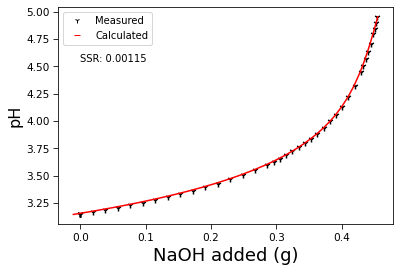

X1 (initial): 90.76813443309462 | pK1(initial):  5.2597335368425755 | H0 : 0.0006988474098043849


In [16]:
for _ in range(20):
    minner_001()
    
figure_001()




//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


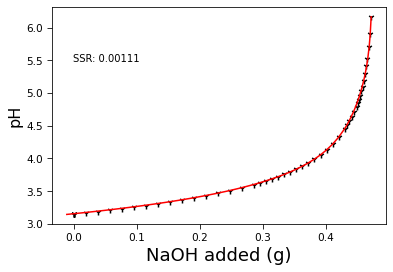

X1: 47.327823339442695 | pK1:  4.857196568935222 | Deviation % (g) NaOH : 0.23457558671349327


In [17]:
for _ in range(20):
    minner_002()
    
figure_002()

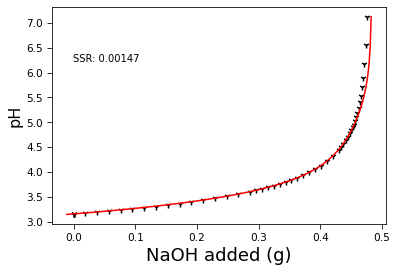

X2: -0.44689442172496646 | pK2:  nan | Deviation % (g) NaOH : 0.3110012108595917


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:393: RuntimeWarning: invalid value encountered in log10


In [18]:
for _ in range(20):
    minner_003()
    
figure_003()

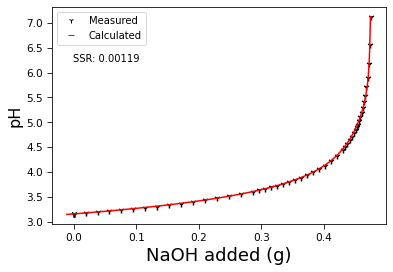

X3: 1.0445546418939522 | pK3:  4.814212172103007 | Deviation % (g) NaOH : 0.25045112311835643


In [19]:
for _ in range(20):
    minner_004()
    
figure_004()

In [132]:



##################################################################
#convert Xi to µmol.kg-1, KXi to pKXi
##################################################################
X1 = X1*10**6
X2 = X2*10**6
X3 = X3*10**6


pK_X1 = -np.log10(K_X1)
pK_X2 = -np.log10(K_X2)
pK_X3 = -np.log10(K_X3)


##################################################################
#Variables to be exported to master excel TA titration
##################################################################
data =    {'Sample ID':[sample_id_TA],
           'HCl M/KG':[C],
           "NaOH M/KG":[C_NaOH],
           'TA':[TA_final_TA],
           'OrgAlk':[TA_final_BT],
           'Initial pH TA':[initial_pH_TA], 
           'Initial pH BT':[initial_pH_BT],
           "H0":[H0],
           
           "X1":[X1],
          
           "pK_X1":[pK_X1],
    
           "X2":[X2],
          
           "pK_X2":[pK_X2],
    
           "X3":[X3],
           
           "pK_X3":[pK_X3],
           
           "SSR_001":[ssr_002],
           "SSR_002":[ssr_003],
           "SSR_003":[ssr_004]
           
           
            
          
           }

final_df = pd.DataFrame(data,       columns = ['Sample ID',
                                               'HCl M/KG',
                                               "NaOH M/KG",
                                               'TA', 
                                               'OrgAlk',
                                               'Initial pH TA',
                                               'Initial pH BT',
                                               
                                               'H0',
                                               
                                               "X1",
                                              
                                               'pK_X1',
    
                                               "X2",
                                               
                                               'pK_X2',
    
                                               "X3",
                                               
                                               'pK_X3',
    
                                               "SSR_001",
                                               "SSR_002",
                                               "SSR_003"
                                               
                                               ])
final_df.insert(0, 'TimeStamp', pd.to_datetime('now').replace(microsecond=0))
#NaOH TITRATION
append_df_to_excel('/Users/dankerr/Desktop/DESKTOP/POSTGRAD/MASTER SEAWATER ANALYSIS/CARBON/Alkalinity Titration/MASTER_SPREADSHEETS/NaCH3COO_spiked_master.xlsx',  final_df, header = None, sheet_name='0.7M NaCl', index=False)




printmd('**DONE**')

                           


**DONE**